In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import gmaps
import scipy.stats as st
#from api_keys import g_key
import numpy as np
import seaborn as sns

In [2]:
# Import base data
complete_df = pd.read_csv('output/output_data_V2.csv')

In [3]:
complete_df.rename(columns={'NOC_x':'NOC'}, inplace=True)

In [4]:
# Separate data into winter/summer
winter_only = complete_df.loc[complete_df['Season']=='Winter',:]
summer_only = complete_df.loc[complete_df['Season']=='Summer',:]

#### Source data has all athlete medal counts.  Need to find Medals per Event in order to eliminate multiple medals for team events.

In [5]:
# Winter: create new columns for Gold, Silver, Bronze. Tally medal results into new columns
winter_medals = winter_only[['NOC','name','Year','Event','Medal','latitude','longitude']].copy()
for index, row in winter_medals.iterrows():
    if winter_medals.loc[index,'Medal'] == 'Gold':
        winter_medals.loc[index,'Gold'] = 1
    elif winter_medals.loc[index,'Medal'] == 'Silver':
        winter_medals.loc[index,'Silver'] = 1
    elif winter_medals.loc[index,'Medal'] == 'Bronze':
        winter_medals.loc[index,'Bronze'] = 1

In [6]:
# Summer: create new columns for Gold, Silver, Bronze. Tally medal results into new columns
summer_medals = summer_only[['NOC','name','Year','Event','Medal','latitude','longitude']].copy()
for index, row in summer_medals.iterrows():
    if summer_medals.loc[index,'Medal'] == 'Gold':
        summer_medals.loc[index,'Gold'] = 1
    elif summer_medals.loc[index,'Medal'] == 'Silver':
        summer_medals.loc[index,'Silver'] = 1
    elif summer_medals.loc[index,'Medal'] == 'Bronze':
        summer_medals.loc[index,'Bronze'] = 1

In [7]:
# Create new dataframes to average latitude and longitude
# Needed because some longitude values are not equal to all decimal places, resulting in incorrect groupby
winter_events = winter_medals.groupby(['NOC','name','Year','Event','latitude','longitude']).mean().reset_index()
summer_events = summer_medals.groupby(['NOC','name','Year','Event','latitude','longitude']).mean().reset_index()

In [8]:
# Create new dataframes
winter_noc = winter_events.groupby(['NOC','name','Year','latitude','longitude'])[['Gold','Silver','Bronze']].sum().reset_index()
summer_noc = summer_events.groupby(['NOC','name','Year','latitude','longitude'])[['Gold','Silver','Bronze']].sum().reset_index()

In [9]:
# Remove Summer years before 1924 to align with Winter years
summer_noc = summer_noc.loc[summer_noc['Year']>=1924,:].copy()

In [10]:
# Create new column to sum all medals won by event
winter_noc['Total Medals'] = winter_noc['Gold']+winter_noc['Silver']+winter_noc['Bronze']
summer_noc['Total Medals'] = summer_noc['Gold']+summer_noc['Silver']+summer_noc['Bronze']

In [11]:
# Sum total medals won by country
winter_df = winter_noc.groupby(['NOC','name','latitude','longitude'])['Gold','Silver','Bronze','Total Medals'].sum().reset_index()
summer_df = summer_noc.groupby(['NOC','name','latitude','longitude'])['Gold','Silver','Bronze','Total Medals'].sum().reset_index()

<ipython-input-11-bd787cfbd077>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  winter_df = winter_noc.groupby(['NOC','name','latitude','longitude'])['Gold','Silver','Bronze','Total Medals'].sum().reset_index()
<ipython-input-11-bd787cfbd077>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  summer_df = summer_noc.groupby(['NOC','name','latitude','longitude'])['Gold','Silver','Bronze','Total Medals'].sum().reset_index()


In [12]:
# Add new columns for percent of total medals won
total_medals_winter = winter_df['Total Medals'].sum()
total_medals_summer = summer_df['Total Medals'].sum()

winter_df['Medals Won %'] = winter_df['Total Medals']/total_medals_winter*100
summer_df['Medals Won %'] = summer_df['Total Medals']/total_medals_summer*100

In [13]:
winter_df

,NOC,name,latitude,longitude,Gold,Silver,Bronze,Total Medals,Medals Won %
0,ALB,Albania,41.153332,20.168331,0.0,0.0,0.0,0.0,0.000000
1,AND,Andorra,42.546245,1.601554,0.0,0.0,0.0,0.0,0.000000
2,ARG,Argentina,-38.416097,-63.616672,0.0,0.0,0.0,0.0,0.000000
3,ARM,Armenia,40.069099,45.038189,0.0,0.0,0.0,0.0,0.000000
4,AUS,Australia,-25.274398,133.775136,6.0,3.0,4.0,13.0,0.668724
...,...,...,...,...,...,...,...,...,...
69,TUR,Turkey,38.963745,35.243322,0.0,0.0,0.0,0.0,0.000000
70,UKR,Ukraine,48.379433,31.165580,2.0,1.0,4.0,7.0,0.360082
71,USA,United States,37.090240,-95.712891,96.0,99.0,84.0,279.0,14.351852
72,UZB,Uzbekistan,41.377491,64.585262,1.0,0.0,0.0,1.0,0.051440


## Heatmap - Medals Won % vs Latitude

In [14]:
# Comment out...not used for analysis

#gmaps.configure(api_key=g_key)
#locations = winter_df[['latitude','longitude']]
#w_medals = winter_df['Medals Won %']
#winter = gmaps.figure()
#heatmap_layer = gmaps.heatmap_layer(locations, weights=w_medals, dissipating=False, max_intensity=20, point_radius = 10)
#winter.add_layer(heatmap_layer)
#winter

In [15]:
# Comment out...not used for analysis

#gmaps.configure(api_key=g_key)
#locations = summer_df[['latitude','longitude']]
#s_medals = summer_df['Medals Won %']
#summer = gmaps.figure()
#heatmap_layer = gmaps.heatmap_layer(locations, weights=s_medals, dissipating=False, max_intensity=20, point_radius = 10)
#summer.add_layer(heatmap_layer)
#summer

# Scatter plot - Medals Won % vs Northern Latitude

In [16]:
# Drop southern latitude countries
winter_df = winter_df.loc[winter_df['latitude']>0,:]
summer_df = summer_df.loc[summer_df['latitude']>0,:]

## Winter Olympics

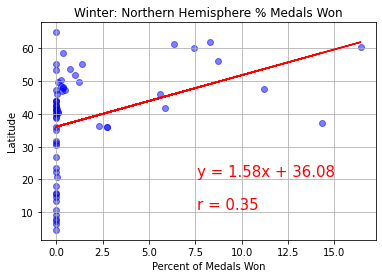

In [78]:
# Plot scatter chart
medals_winter = winter_df['Medals Won %']
lat_winter = winter_df['latitude']

slope_w, intercept_w, rvalue_w = st.linregress(medals_winter,lat_winter)[0:3]
line_w = slope_w*medals_winter+intercept_w

plt.scatter(medals_winter, lat_winter, facecolors="blue", alpha=0.5)
plt.plot(medals_winter,line_w, color='r')

plt.title('Winter: Northern Hemisphere % Medals Won')
plt.xlabel('Percent of Medals Won')
plt.ylabel('Latitude')

line_eq_w = f'y = {round(slope_w,2)}x + {round(intercept_w,2)}'
r_w = f'r = {round(rvalue_w,2)}'
plt.annotate(line_eq_w,(7.6,21),fontsize=15,color="red")
plt.annotate(r_w,(7.6,11),fontsize=15,color="red")

plt.grid()

plt.savefig('output/winter-latitude performance.png', facecolor='w')
plt.show()

## Summer Olympics

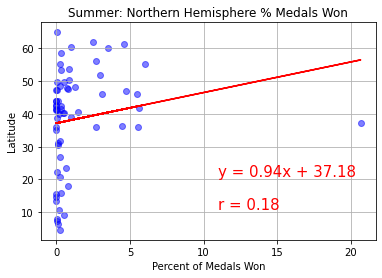

In [93]:
# Plot scatter chart
medals_summer = summer_df['Medals Won %']
lat_summer = summer_df['latitude']

slope_s, intercept_s, rvalue_s = st.linregress(medals_summer,lat_summer)[0:3]
line_s = slope_s*medals_summer+intercept_s

plt.scatter(medals_summer, lat_summer, marker="o", facecolors="blue", alpha=0.5)
plt.plot(medals_summer,line_s, color='r')

plt.title('Summer: Northern Hemisphere % Medals Won')
plt.xlabel('Percent of Medals Won')
plt.ylabel('Latitude')

line_eq_s = f'y = {round(slope_s,2)}x + {round(intercept_s,2)}'
r_s = f'r = {round(rvalue_s,2)}'
plt.annotate(line_eq_s,(11,21),fontsize=15,color="red")
plt.annotate(r_s,(11,11),fontsize=15,color="red")

plt.grid()

plt.savefig('output/summer-latitude performance.png', facecolor='w')
plt.show()